# LSTM for Production: Univariate

In this repo, we will use the production data of the [Equinor’s Volve data set](https://www.equinor.com/energy/volve-data-sharing), a publicly available subsurface data set, to train three separate models to predict oil, gas, and water production respectively.

If you are using Colab to run this notebook, you have to run the below cell. Change the `content/drive/My Drive` according to your directly. If you are running this notebook on a local environment i.e. Anaconda or VS code, ignore the below cell. But make sure your notebook and dataset are in the same directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')
os.path.exists('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

First, import the libraries and framework to use.  
I am using `random seed 42` to reproduce the same random number everytime I run the code.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.keras.utils.set_random_seed(42)

Now import the Excel file named `Volve_production_data` which contains our data.  
Take a moment to understand the data.

In [ ]:
full_data = pd.read_excel('Volve_production_data.xlsx')
full_data

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15629,2016-09-14,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.07776,0.22879,0.01862,0.0,0.0,0.0,NaN,production,OP
15630,2016-09-15,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.08545,0.22914,0.00631,0.0,0.0,0.0,NaN,production,OP
15631,2016-09-16,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.08544,0.22896,0.01181,0.0,0.0,0.0,NaN,production,OP
15632,2016-09-17,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.07497,0.22846,0.02576,0.0,0.0,0.0,NaN,production,OP


Let's print out the names of all columns.

In [ ]:
column_names = full_data.columns
print(column_names)

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')


The `Vovle` dataset has around 40,000 files, including:
* Geophysical data, including interpretations
* Geo-Science Archive
* Production data
* Report
* Static models and dynamic simulations
* Seismic data
* Well logs
* Well Technical Data
* Realtime drilling data

To optimize model performance, it is essential to extract all the relevant features from the dataset. This involves both spatial (static) and temporal (dynamic) data. For example, extracting features from the Surface Operational Conditions, Details of all Wells Architecture, Well Logs, Core Analysis, Well Tests, Seismic, Production Logs, Temperature Survey, Production/Injection History, etc. to build a comprehensive reservoir model.

However, feature extraction is itself a comprehensive topic, and for the purpose of this discussion, my focus is on the machine learning (ML) aspect rather than delving deep into feature extraction. Therefore, we will use only dynamic (production) data such as: `ON_STREAM_HRS, AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATURE, AVG_DP_TUBING, AVG_ANNULUS_PRESS, AVG_CHOKE_SIZE_P, AVG_CHOKE_UOM, AVG_WHP_P, AVG_WHT_P, DP_CHOKE_SIZE,` and `BORE_OIL_VOL` to train our LSTM model.


Alright, I will do the code for oil prediction, and later, you can easily adapt it for gas and water prediction with a simple modification.

Let's see the names of different wells and their types:

In [ ]:
unique_well_bore = full_data['NPD_WELL_BORE_NAME'].unique()
print("All Unique Well Bore Names:")
print(unique_well_bore)

unique_producer_well_bore = full_data[full_data['FLOW_KIND'] == 'production']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'production':")
print(unique_producer_well_bore)

unique_injection_well_bore = full_data[full_data['FLOW_KIND'] == 'injection']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'injection':")
print(unique_injection_well_bore)


All Unique Well Bore Names:
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-4'
 '15/9-F-5']

Well Bore Names for 'production':
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-5']

Well Bore Names for 'injection':
['15/9-F-4' '15/9-F-5']


Notice that Well 15/9-F-5 is on both list (production and injection). Because it was a water injector and then was converted into an oil producer on April 11, 2016. Moreover, the longest-producing well is 15/9-F-12. See [this dissertation](https://researchrepository.wvu.edu/etd/11970/) for more details.

The below cell will sort the data in chronological order:

In [ ]:
full_data = full_data.sort_values(by='DATEPRD')

Now let's define our data to use. I will use the data of the longest producing well (15/9-F-12), but if you want to use the full data, you just need to uncomment the `Full data` code and comment out the `F-12 data` code. And, if you want to train a model for gas or water, you just need to replace the `BORE_OIL_VOL` with `BORE_GAS_VOL` or `BORE_WAT_VOL` respectively.  
The `DATEPRD` column is only for plotting purposes.

In [ ]:
# F-12 data
data = full_data[(full_data['NPD_WELL_BORE_NAME'] == '15/9-F-12')][['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]

# Full data
#data = full_data[['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]

Let's see how many samples we have:

In [ ]:
print(f'We have {data.shape[0]} samples')

We have 3056 samples


Check if this **3056** has any null values

In [ ]:
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                      0
ON_STREAM_HRS                0
AVG_DOWNHOLE_PRESSURE        6
AVG_DOWNHOLE_TEMPERATURE     6
AVG_DP_TUBING                6
AVG_ANNULUS_PRESS           13
AVG_CHOKE_SIZE_P            44
AVG_WHP_P                    0
AVG_WHT_P                    0
DP_CHOKE_SIZE                0
BORE_OIL_VOL                 0
dtype: int64


Alright, we have 6 null values for `AVG_DOWNHOLE_PRESSURE`, `AVG_DOWNHOLE_TEMPERATURE`, `AVG_DP_TUBING` each and 13 & 44 null values in `AVG_ANNULUS_PRESS` and `AVG_CHOKE_SIZE_P` respectively.

You may want to use different methods to patch the missing values but, I am simply deleting these cells as they are only 2% of the total data.  
The below code will delete all the null values.

In [ ]:
data = data.dropna()
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                     0
ON_STREAM_HRS               0
AVG_DOWNHOLE_PRESSURE       0
AVG_DOWNHOLE_TEMPERATURE    0
AVG_DP_TUBING               0
AVG_ANNULUS_PRESS           0
AVG_CHOKE_SIZE_P            0
AVG_WHP_P                   0
AVG_WHT_P                   0
DP_CHOKE_SIZE               0
BORE_OIL_VOL                0
dtype: int64


Let's see our data:

In [ ]:
data

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL
1911,2008-02-12,11.50,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,284.65
1912,2008-02-13,24.00,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,1869.70
1913,2008-02-14,22.50,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,3124.09
1914,2008-02-15,23.15,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,2608.28
1915,2008-02-16,24.00,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,3051.80
...,...,...,...,...,...,...,...,...,...,...,...
4962,2016-09-13,0.00,0.000000,0.000000,0.000000,19.958840,0.992907,0.000000,0.000000,0.012620,0.00
4963,2016-09-14,0.00,0.000000,0.000000,0.000000,19.958630,0.973044,0.000000,0.000000,0.015740,0.00
4964,2016-09-15,0.00,0.000000,0.000000,0.000000,19.958870,0.977784,0.000000,0.000000,0.023690,0.00
4965,2016-09-16,0.00,0.000000,0.000000,0.000000,19.958730,0.961007,0.000000,0.000000,0.024660,0.00


So, we have now zero null values, **2993** samples and 11 columns. Remember that the date column is only for plotting purpose, so, we have **10** features.

Plot the oil production (`BORE_OIL_VOL`) against the date (`DATEPRD`).

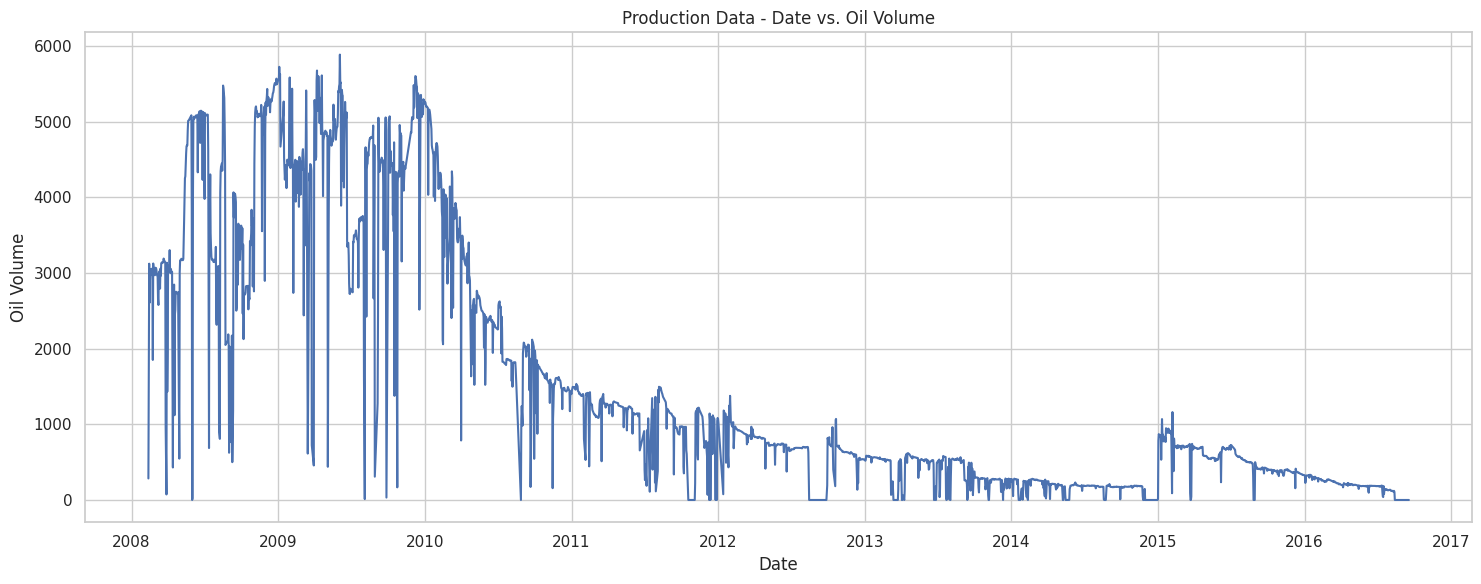

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(data=data, x='DATEPRD', y='BORE_OIL_VOL',errorbar=None)
plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.title('Production Data - Date vs. Oil Volume')
plt.tight_layout()
plt.show()

We are using using `MinMaxScaler` of sklearn to scale our features.  
Make sure to replace the `BORE_OIL_VOL` with correct term if you are modeling for gas or water.

In [ ]:
tf.keras.utils.set_random_seed(42)
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']
data_to_scale = data[columns_to_scale].copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale)

# Add the 'DATEPRD' column as the first column. Later, we will use it for plotting purpose.
data_scaled_df.insert(0, 'DATEPRD', data['DATEPRD'])

In [ ]:
data_scaled_df

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL
0,NaT,0.460,0.978644,0.971263,0.719611,0.620908,0.144844,0.777839,0.176238,0.745028,0.048338
1,NaT,0.960,0.962689,0.980421,0.651296,0.548525,0.228330,0.880400,0.577278,0.722027,0.317507
2,NaT,0.900,0.939029,0.983889,0.650306,0.421708,0.312500,0.828179,0.786705,0.645493,0.530524
3,NaT,0.926,0.945627,0.983669,0.646602,0.175352,0.285189,0.850847,0.757051,0.678770,0.442930
4,NaT,0.960,0.940140,0.984220,0.645418,0.412548,0.302279,0.840679,0.773517,0.663528,0.518248
...,...,...,...,...,...,...,...,...,...,...,...
2988,2011-02-08,0.000,0.000000,0.000000,0.000000,0.664855,0.009929,0.000000,0.000000,0.000102,0.000000
2989,2011-02-09,0.000,0.000000,0.000000,0.000000,0.664848,0.009730,0.000000,0.000000,0.000127,0.000000
2990,2011-02-10,0.000,0.000000,0.000000,0.000000,0.664856,0.009778,0.000000,0.000000,0.000191,0.000000
2991,2011-02-11,0.000,0.000000,0.000000,0.000000,0.664852,0.009610,0.000000,0.000000,0.000199,0.000000


Our data has all values between 0 and 1.

Here comes the important part:  
In LSTM, we feed the data of the previous time step, and predict the target for the current time step. In our case, we will feed all the features, including oil production, of the previous time step (previous day) and we will predict the oil production for the current time step (for today).

So, let's divide our data into features and target (label). Later, we will use `windowed_dataset` function to have features for previous time step and target for current time step.  

Make sure to replace the `BORE_OIL_VOL` with correct term if you are modeling for gas or water.

In [ ]:
features = data_scaled_df[['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]
target = data_scaled_df[['BORE_OIL_VOL']]

LSTM expects Numpy data type, so the below code will convert our data, DataFrame type, into Numpy data type.

In [ ]:
features = features.to_numpy()
target = target.to_numpy()

Now we will use sklearn to split our data into 70% training, 15% validation, and 15% test data set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(features, target, test_size=0.3, shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print("Number of samples in train set:", X_train.shape[0])
print("Number of samples in validation set:", X_val.shape[0])
print("Number of samples in test set:", X_test.shape[0])

Number of samples in train set: 2095
Number of samples in validation set: 449
Number of samples in test set: 449


Alright! So for so good. Let's visualize our data after the split.

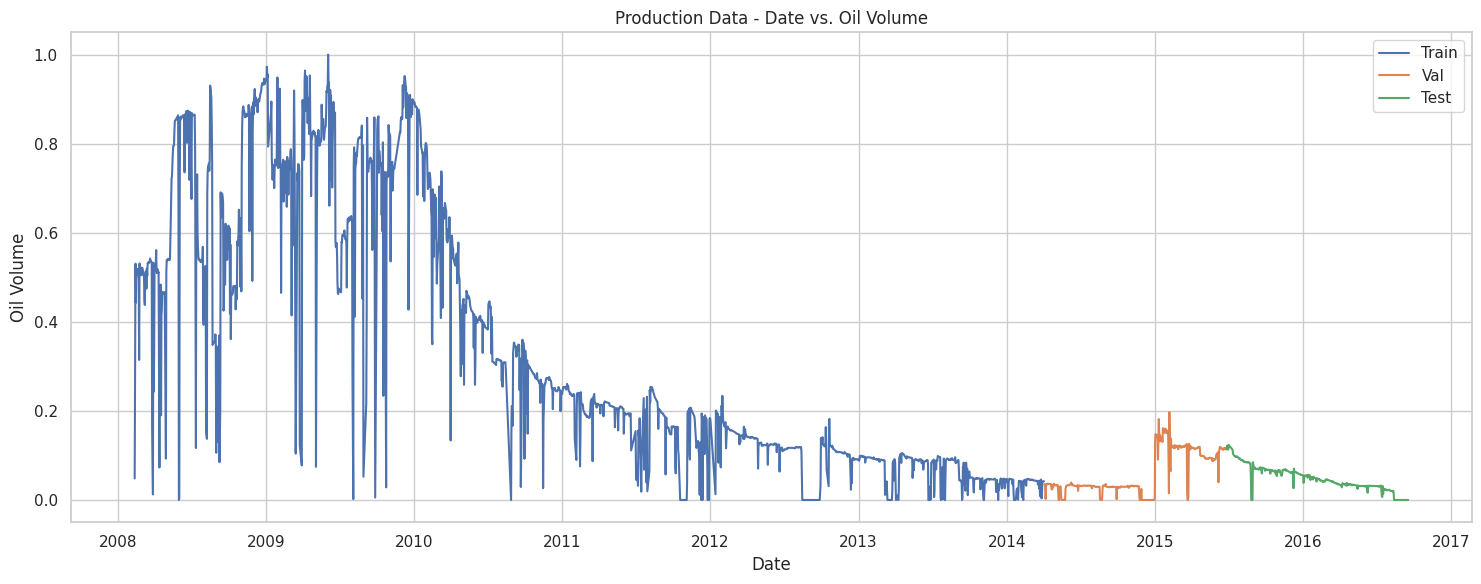

In [ ]:
plt.figure(figsize=(15, 6))

sns.lineplot(x=data['DATEPRD'][:Y_train.shape[0]].ravel(), y=Y_train.ravel(), label='Train', errorbar=None)
sns.lineplot(x=data['DATEPRD'][Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]].ravel(), y=Y_val.ravel(), label='Val', errorbar=None)
sns.lineplot(x=data['DATEPRD'][Y_train.shape[0] + Y_val.shape[0]:Y_train.shape[0] + Y_val.shape[0] + Y_test.shape[0]].ravel(), y=Y_test.ravel(), label='Test', errorbar=None)

plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.title('Production Data - Date vs. Oil Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Okay! The below code will divide features and target into previous and current time steps. This is the major concept of the LSTM.
Our data will be:
* All the features (including oil production) of the previous day, target (oil production) of the current day
* Then all the features of the current day, target (oil production) of the next day
* and so on...

If you are not familiar with the concept, I have an explanation of the code below. Please click on the green text "Click here for Explanation" and you will see the text. Click again and it will hide the text.

In [ ]:
def windowed_dataset(features, target, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((features, target))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))
    dataset = dataset.map(lambda x, y: (x[:-1], y[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

<details>
  <summary><font size="3" color="darkgreen"><b>Click here for Explanation</b></font></summary>
  
  Here's a step-by-step explanation of each part of the code:

`def windowed_dataset(features, target, window_size, batch_size):`
    This line defines a Python function named windowed_dataset that takes four arguments: features, target, window_size, and batch_size.

`dataset = tf.data.Dataset.from_tensor_slices((features, target))`
    This line creates a TensorFlow dataset using tf.data.Dataset.from_tensor_slices. It takes two arguments, features and target, and creates a dataset where each element is a pair consisting of a feature and its corresponding target. This is a common way to create a dataset from arrays.

`dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)`
This line applies a windowing operation to the dataset. It divides the dataset into overlapping windows of size `window_size + 1,` where window_size is a parameter provided to the function. The `shift=1` argument means that the windows will shift by one element at a time, creating overlapping windows. `drop_remainder=True` ensures that windows with fewer than `window_size + 1` elements are dropped.

`dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))`
This line flattens the nested dataset created by the window operation. It uses flat_map to convert each window into a new dataset using a lambda function. Within this lambda function, x and y represent a window of features and target, respectively. `tf.data.Dataset.zip` is used to create pairs of (features_window, target_window), where each window contains `window_size + 1` elements. This essentially stacks the elements of each window together.

`dataset = dataset.map(lambda x, y: (x[:-1], y[1:]))`
This line maps a lambda function over the dataset to extract the input-output pairs for training. It takes each pair (features_window, target_window) and returns a new pair (input_sequence, target_sequence) where input_sequence is all elements of features_window except the last one `(x[:-1])`, and target_sequence is all elements of target_window except the first one `(y[1:])`. This prepares the data for a sequence prediction task where the model predicts the next element in a sequence based on the previous elements.

`dataset = dataset.batch(batch_size).prefetch(1)`
This line batches the dataset into mini-batches of size batch_size. Batching is commonly used in machine learning to process data in smaller chunks. The `prefetch(1)` operation prefetches one batch asynchronously to improve data loading efficiency.
return dataset

Finally, the function returns the prepared dataset, which is ready to be used for training a machine learning model.
</details>

Now apply the above function to our data.

In [ ]:
tf.keras.utils.set_random_seed(42)
window_size = 5
batch_size = 32
train_set = windowed_dataset(X_train, Y_train, window_size, batch_size)
val_set = windowed_dataset(X_val, Y_val, window_size, batch_size)
test_set = windowed_dataset(X_test, Y_test, window_size, batch_size)

Now check the shape of our features and target, after applying the window function.

In [ ]:
train_iterator = iter(train_set)
first_element = next(train_iterator)
features_shape = first_element[0].shape
target_shape = first_element[1].shape

print("Features shape:", features_shape)
print("Target shape:", target_shape)

Features shape: (32, 5, 10)
Target shape: (32, 5, 1)


The shape of **input** is **`(batch_size, window_size, features)`**  
The shape of **output** is **`(batch_size, window_size, target)`**

- `batch_size` is 32, which means we process 32 samples simultaneously.
- `window_size` is 5, indicating that each sample spans 5 time steps or days.
- `features` is 10, representing the number of input data points at each time step.
- `target` is 1, representing oil production for each time step.

To provide a clearer understanding, let's examine the data for the first batch. Run the below cell to see:

- We have 5 time steps (5 days), each consisting of 10 input data points (features) and 1 target value.
- Note that out of 10 input data, the last one is the oil production of the previous day.
- **You can observe that the target (oil production) for day 1 is become an input for day 2.**
- **Target for day 2 is become an input for day 3 and this pattern continues for subsequent days.**

In [ ]:
first_sample = (first_element[0][0], first_element[1][0])

for day in range(len(first_sample[0])):
    print(f"\033[1;34mDay {day + 1} Data:\033[0m")
    print(f"Input data for day {day + 1}: {first_sample[0][day]}")
    print(f"Target (oil production) for day {day + 2}: {first_sample[1][day]}")
    print()

Day 1 Data:
Input data for day 1: [0.46       0.97864427 0.97126284 0.71961053 0.62090818 0.14484431
 0.77783947 0.17623791 0.74502803 0.04833843]
Target (oil production) for day 2: [0.31750695]

Day 2 Data:
Input data for day 2: [0.96       0.96268884 0.98042132 0.65129648 0.54852549 0.22832986
 0.8803996  0.57727789 0.72202698 0.31750695]
Target (oil production) for day 3: [0.53052377]

Day 3 Data:
Input data for day 3: [0.9        0.93902947 0.9838889  0.65030582 0.42170758 0.31249966
 0.82817946 0.78670451 0.64549255 0.53052377]
Target (oil production) for day 4: [0.44293043]

Day 4 Data:
Input data for day 4: [0.926      0.94562662 0.98366927 0.64660201 0.17535249 0.2851893
 0.85084674 0.75705139 0.67877023 0.44293043]
Target (oil production) for day 5: [0.51824769]

Day 5 Data:
Input data for day 5: [0.96       0.94013964 0.9842203  0.64541839 0.41254845 0.30227902
 0.84067882 0.77351717 0.66352757 0.51824769]
Target (oil production) for day 6: [0.50650145]



Phew! We did a lot of work.

Below, we will define our LSTM model. After trying out the different architectures, I found that the below gave the best result.

In [ ]:
def LSTM_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128,return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])

    return model

Now start training our model. I am using `EarlyStopping` from TensorFlow to stop our training early when we do not see any significant improvement on validation data set.

The below cell may take 10 minutes to an hour, depending on your GPU/CPU.

In [ ]:
tf.keras.utils.set_random_seed(42)

model = LSTM_model()
epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=125, restore_best_weights=True)
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    shuffle=False,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/1000
66/66 [==============================] - 9s 39ms/step - loss: 0.1229 - val_loss: 0.0148
Epoch 2/1000
66/66 [==============================] - 1s 19ms/step - loss: 0.0560 - val_loss: 0.0087
Epoch 3/1000
66/66 [==============================] - 3s 46ms/step - loss: 0.0383 - val_loss: 0.0060
Epoch 4/1000
66/66 [==============================] - 2s 34ms/step - loss: 0.0317 - val_loss: 0.0050
Epoch 5/1000
66/66 [==============================] - 1s 22ms/step - loss: 0.0304 - val_loss: 0.0041
Epoch 6/1000
66/66 [==============================] - 1s 22ms/step - loss: 0.0255 - val_loss: 0.0037
Epoch 7/1000
66/66 [==============================] - 1s 22ms/step - loss: 0.0241 - val_loss: 0.0030
Epoch 8/1000
66/66 [==============================] - 1s 20ms/step - loss: 0.0225 - val_loss: 0.0024
Epoch 9/1000
66/66 [==============================] - 2s 27ms/step - loss: 0.0196 - val_loss: 0.0019
Epoch 10/1000
66/66 [==============================] - 3s 52ms/step - loss: 0.0180 - val_lo

Okay! Our model is trained and `EarlyStopping` activated around 400 epochs, saving extra 600 epochs.

Let's plot the training and validation loss.

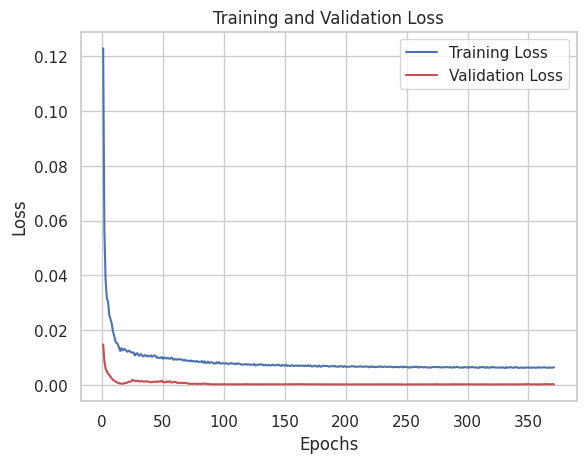

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now use this trained model to predict the oil production on test set

In [ ]:
predictions = model.predict(test_set)

14/14 [==============================] - 1s 8ms/step


The below code concatenates the `X_test` with predicted data, reverses the scaling, and adds the `PREDICTED_OIL` column to the data.

In [ ]:
df_pred = pd.concat([pd.DataFrame(X_test[:,1:][window_size:]),pd.DataFrame(predictions)], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = data.iloc[-predictions.shape[0]:].copy()
df_final['PREDICTED_OIL'] = rev_trans[:,-1]

Let's plot the predicted and real data

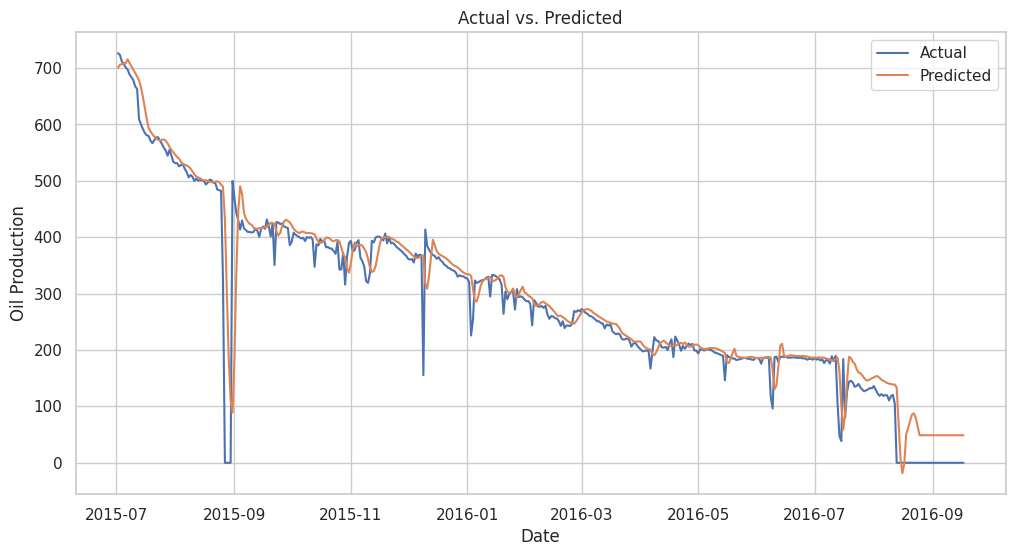

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_final, x='DATEPRD', y='BORE_OIL_VOL', label='Actual', errorbar=None)
sns.lineplot(data=df_final, x='DATEPRD', y='PREDICTED_OIL', label='Predicted', errorbar=None)
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

Bingo! Excellent match.

Now create a DataFrame named `compare_data` having columns `DATEPRD`, `BORE_OIL_VOL`, and `PREDICTED_OIL` to compare actual and predicted data values side by side.

In [ ]:
compare_data = df_final[['DATEPRD', 'BORE_OIL_VOL', 'PREDICTED_OIL']]
compare_data

,DATEPRD,BORE_OIL_VOL,PREDICTED_OIL
4523,2015-07-02,726.33,700.656111
4524,2015-07-03,723.42,706.033942
4525,2015-07-04,711.93,706.854389
4526,2015-07-05,707.58,708.506076
4527,2015-07-06,701.27,708.432104
...,...,...,...
4962,2016-09-13,0.00,48.810617
4963,2016-09-14,0.00,48.821585
4964,2016-09-15,0.00,48.830886
4965,2016-09-16,0.00,48.833958


I trained two separate models for gas and water and here is the result of the blind dataset:

![gas_model](gas_model.png)
![water_model](water_model.png)

Now it's your turn. Please try to train your own model, but instead of using only one well data, use the full set of data. Try hyperparameter tunings, like more epochs, layers, etc., to have good match.  

Best of luck. . .